In [1]:
import sys
sys.path.append('..')

from src.pdf_loader import load_pdfs, split_documents, get_document_stats
from src.config import PDF_DIRECTORY
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Setup complete!")

2026-02-15 09:55:48,132 - matplotlib.font_manager - INFO - generated new fontManager


✅ Setup complete!


In [2]:
print(f"Loading PDFs from: {PDF_DIRECTORY}\n")
documents = load_pdfs()
stats = get_document_stats(documents)

print("📊 DATASET STATISTICS")
print("="*80)
print(f"Total Pages: {stats['total_pages']}")
print(f"Total Characters: {stats['total_characters']:,}")
print(f"Average Page Length: {stats['avg_page_length']:.0f} chars")
print(f"Unique PDFs: {stats['unique_sources']}")

2026-02-15 10:09:49,477 - src.pdf_loader - INFO - Loading PDFs from d:\Personal Trainer Assistant\notebooks\..\PDFs
2026-02-15 10:09:49,483 - src.pdf_loader - INFO - Found 35 PDF files


Loading PDFs from: d:\Personal Trainer Assistant\notebooks\..\PDFs


PDF FILES BY CATEGORY:
  LIFESTYLE: 4 files
  NUTRITION: 14 files
  TRAINING: 17 files



100%|██████████| 35/35 [00:50<00:00,  1.44s/it]
2026-02-15 10:10:39,969 - src.pdf_loader - INFO - Loaded 2277 pages from 35 PDFs


📊 DATASET STATISTICS
Total Pages: 2277
Total Characters: 3,147,473
Average Page Length: 1382 chars
Unique PDFs: 35


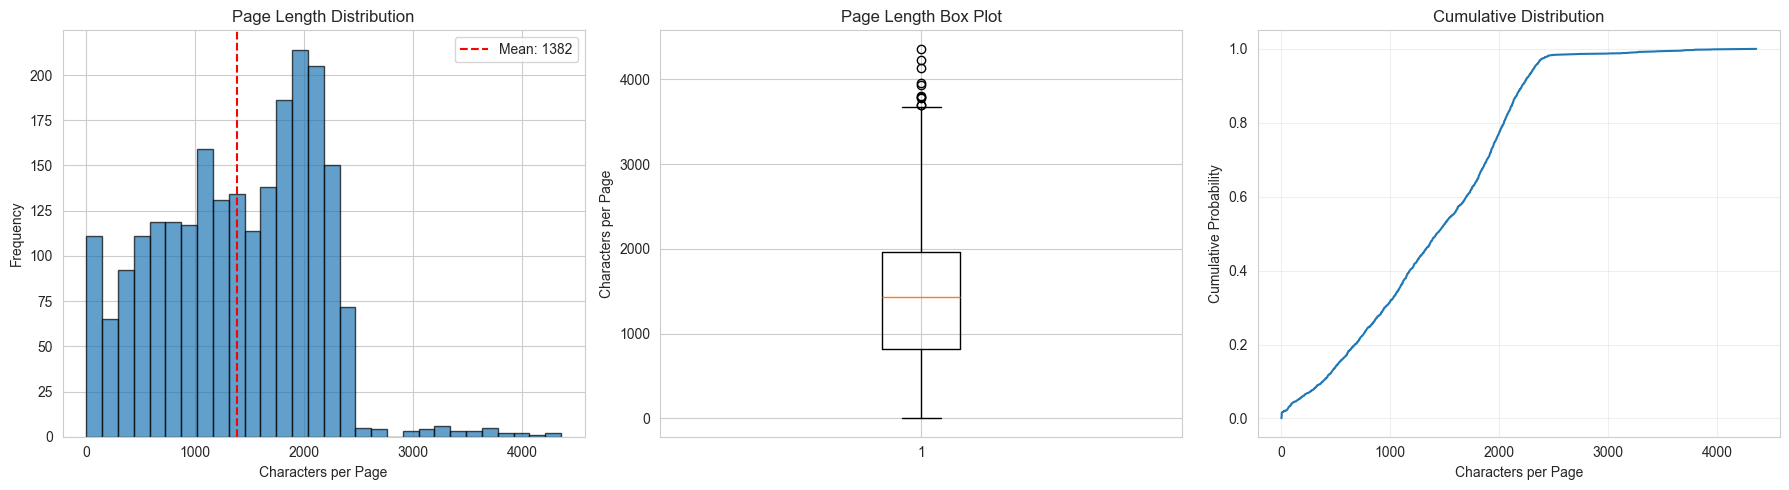


📈 Statistics:
  Min: 0 chars
  Max: 4,360 chars
  Median: 1,427 chars
  Std Dev: 720 chars


In [3]:
page_lengths = [len(doc.page_content) for doc in documents]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(page_lengths, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Characters per Page')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Page Length Distribution')
axes[0].axvline(np.mean(page_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(page_lengths):.0f}')
axes[0].legend()

# Box plot
axes[1].boxplot(page_lengths)
axes[1].set_ylabel('Characters per Page')
axes[1].set_title('Page Length Box Plot')

# Cumulative distribution
sorted_lengths = np.sort(page_lengths)
cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
axes[2].plot(sorted_lengths, cumulative)
axes[2].set_xlabel('Characters per Page')
axes[2].set_ylabel('Cumulative Probability')
axes[2].set_title('Cumulative Distribution')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📈 Statistics:")
print(f"  Min: {min(page_lengths):,} chars")
print(f"  Max: {max(page_lengths):,} chars")
print(f"  Median: {np.median(page_lengths):,.0f} chars")
print(f"  Std Dev: {np.std(page_lengths):,.0f} chars")

2026-02-15 10:13:54,294 - src.pdf_loader - INFO - Splitting documents: chunk_size=1000, overlap=200



Adding metadata to chunks...


Processing chunks: 100%|██████████| 4687/4687 [00:00<00:00, 118337.52it/s]
2026-02-15 10:13:54,525 - src.pdf_loader - INFO - Created 4687 chunks



CHUNKS BY CATEGORY:
  LIFESTYLE: 473 chunks
  NUTRITION: 2509 chunks
  TRAINING: 1705 chunks

🔪 CHUNKING STATISTICS:
  Total Chunks: 4687
  Avg Chunk Length: 757 chars
  Avg Words per Chunk: 119
  Chunks per Page: 2.06

📊 CHUNKS BY CATEGORY:
           Chunks
nutrition    2509
training     1705
lifestyle     473


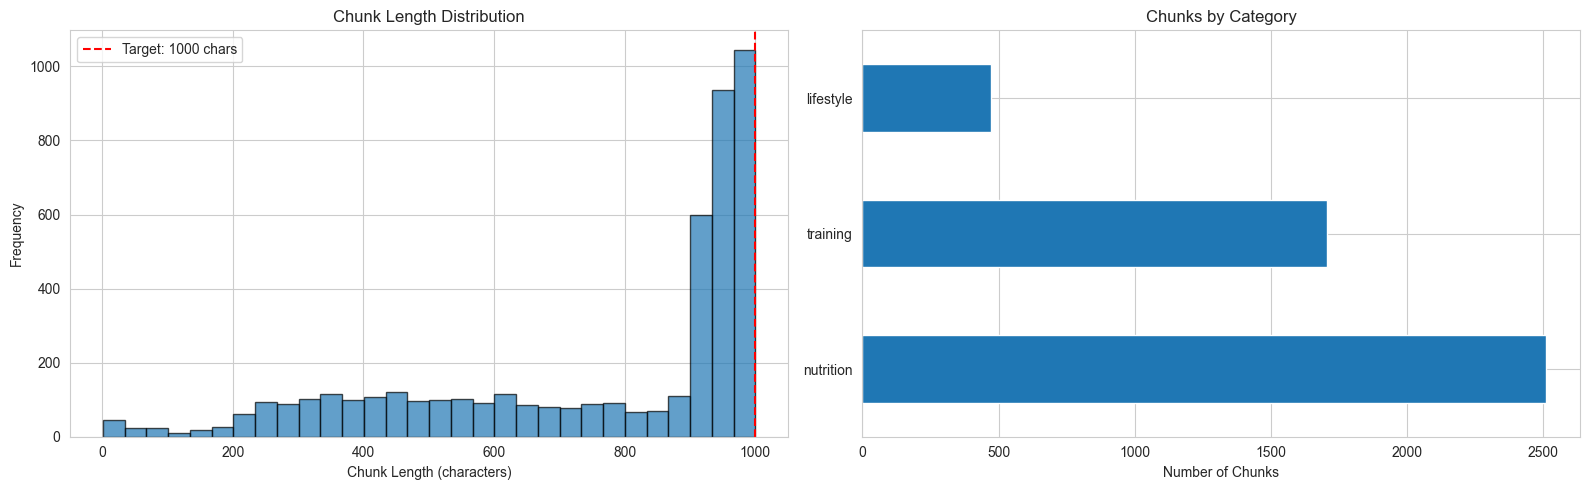

In [5]:
chunks = split_documents(documents)

chunk_lengths = [len(chunk.page_content) for chunk in chunks]
chunk_tokens_approx = [len(chunk.page_content.split()) for chunk in chunks]

print(f"\n🔪 CHUNKING STATISTICS:")
print(f"  Total Chunks: {len(chunks)}")
print(f"  Avg Chunk Length: {np.mean(chunk_lengths):.0f} chars")
print(f"  Avg Words per Chunk: {np.mean(chunk_tokens_approx):.0f}")
print(f"  Chunks per Page: {len(chunks) / len(documents):.2f}")

# Chunk distribution by category
chunk_categories = [chunk.metadata.get('category', 'unknown') for chunk in chunks]
chunk_cat_counts = Counter(chunk_categories)

df_chunk_cats = pd.DataFrame.from_dict(chunk_cat_counts, orient='index', columns=['Chunks'])
df_chunk_cats = df_chunk_cats.sort_values('Chunks', ascending=False)

print("\n📊 CHUNKS BY CATEGORY:")
print(df_chunk_cats)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Chunk length distribution
axes[0].hist(chunk_lengths, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(1000, color='red', linestyle='--', label='Target: 1000 chars')
axes[0].set_xlabel('Chunk Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Chunk Length Distribution')
axes[0].legend()

# Chunks by category
df_chunk_cats.plot(kind='barh', ax=axes[1], legend=False)
axes[1].set_title('Chunks by Category')
axes[1].set_xlabel('Number of Chunks')

plt.tight_layout()
plt.show()


🔍 KEYWORD FREQUENCY (pages containing):
             Pages
muscle         916
training       826
exercise       595
protein        417
recovery       155
hypertrophy     92
nutrition       78
cardio          57


<Figure size 1200x600 with 0 Axes>

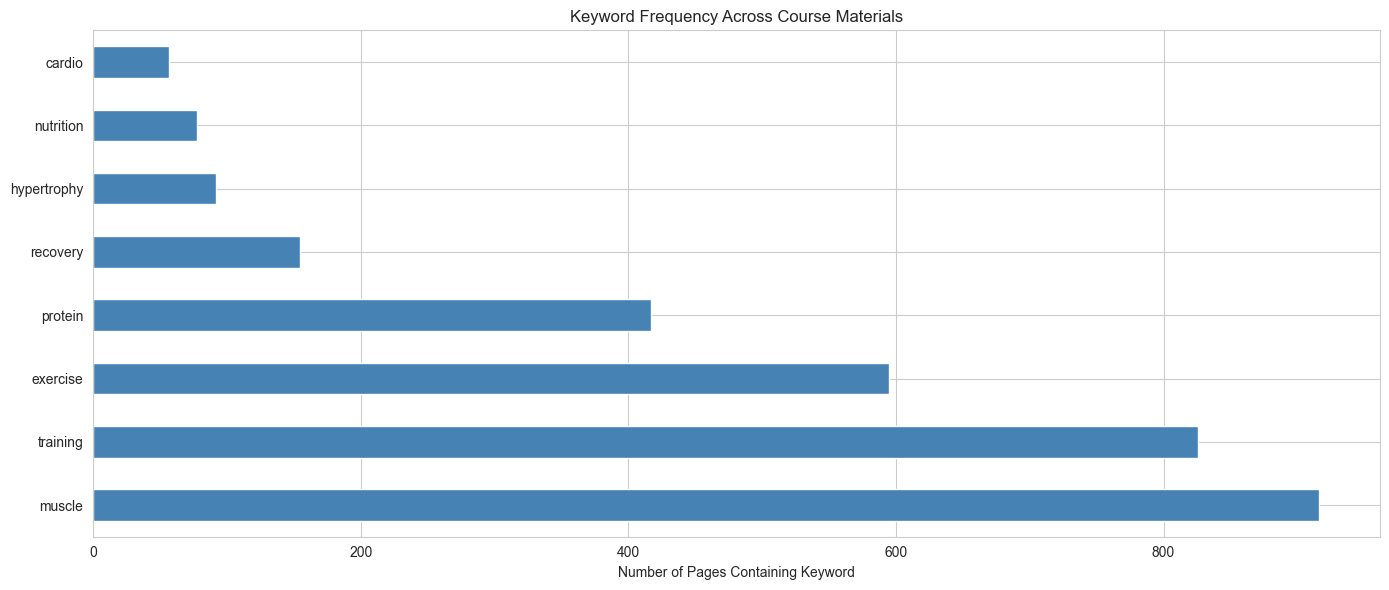

In [6]:
import re

keywords = {
    'protein': r'\bprotein\b',
    'training': r'\btraining\b',
    'muscle': r'\bmuscle\b',
    'hypertrophy': r'\bhypertrophy\b',
    'exercise': r'\bexercise\b',
    'cardio': r'\bcardio\b',
    'nutrition': r'\bnutrition\b',
    'recovery': r'\brecovery\b'
}

keyword_counts = {}
for keyword, pattern in keywords.items():
    count = sum(1 for doc in documents if re.search(pattern, doc.page_content, re.IGNORECASE))
    keyword_counts[keyword] = count

df_keywords = pd.DataFrame.from_dict(keyword_counts, orient='index', columns=['Pages'])
df_keywords = df_keywords.sort_values('Pages', ascending=False)

print("\n🔍 KEYWORD FREQUENCY (pages containing):")
print(df_keywords)

# Visualize
plt.figure(figsize=(12, 6))
df_keywords.plot(kind='barh', legend=False, color='steelblue')
plt.title('Keyword Frequency Across Course Materials')
plt.xlabel('Number of Pages Containing Keyword')
plt.tight_layout()
plt.show()

In [7]:
print("\n" + "="*80)
print("📋 DATASET SUMMARY REPORT")
print("="*80)
print(f"\n📚 Course Materials:")
print(f"  • Total PDFs: {stats['unique_sources']}")
print(f"  • Total Pages: {stats['total_pages']}")
print(f"  • Total Characters: {stats['total_characters']:,}")
print(f"\n🔪 Chunking:")
print(f"  • Total Chunks: {len(chunks)}")
print(f"  • Avg Chunk Size: {np.mean(chunk_lengths):.0f} chars")
print(f"  • Chunking Ratio: {len(chunks) / len(documents):.2f} chunks/page")
print(f"\n📊 Categories:")
for cat, count in df_chunk_cats.iterrows():
    print(f"  • {cat.upper()}: {count['Chunks']} chunks ({count['Chunks']/len(chunks)*100:.1f}%)")
print("\n" + "="*80)


📋 DATASET SUMMARY REPORT

📚 Course Materials:
  • Total PDFs: 35
  • Total Pages: 2277
  • Total Characters: 3,147,473

🔪 Chunking:
  • Total Chunks: 4687
  • Avg Chunk Size: 757 chars
  • Chunking Ratio: 2.06 chunks/page

📊 Categories:
  • NUTRITION: 2509 chunks (53.5%)
  • TRAINING: 1705 chunks (36.4%)
  • LIFESTYLE: 473 chunks (10.1%)

